# 라이브러리 호출

In [1]:
import os
import sys
import re
import pandas as pd
import numpy as np
import torch
from collections import Counter
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)

# 한글 폰트 설정

# plt.rcParams['font.family'] = 'AppleGothic' # Mac
plt.rcParams['font.family'] = 'NanumGothic' # Windows
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 데이터 불러오기

In [2]:
train_augmented_rp = pd.read_csv("../data/augmented/train_augmented_rp.csv")
train_augmented_rp.head()

,fname,dialogue,summary,topic
0,train_396-rp,"#Person1#: 안녕하세요, 잭 계세요?\n#Person2#: 접니다.\n#Person1#: 잭! 오랜만이야, 로즈야.\n#Person2#: 안녕 로즈, 잘 지냈어?\n#Person1#: 응, 고마워. 이번 토요일에 친구들 모아서 저녁 먹을 건데 같이 가자.\n#Person2#: 좋아. 몇 시에 가면 돼?\n#Person1#: 여섯 시 어때?",로즈는 잭에게 전화를 걸어 이번 토요일에 열리는 저녁 식사에 초대했다.,저녁 초대
1,train_247-rp,"#Person1#: 면접 때 어떤 옷을 입으면 좋을지 고민이네요.\n#Person2#: 정장에 넥타이를 매는 것이 면접에 적합할 것 같아요.\n#Person1#: 면접 중에 긴장할까봐 걱정이에요.\n#Person2#: 긴장하지 말고, 자신감을 가지고 자신을 잘 표현하세요.","#Person2#는 #Person1#에게 면접 복장으로 정장과 넥타이를 추천하고, 긴장을 풀고 자신을 잘 표현하라고 제안했습니다.",면접 준비
2,train_9260-rp,"#Person1#: 존, 동기부여에 대해 궁금한 점이 있어요. 왜 지역 사람들과 함께 사업을 시작했는지 이유가 무엇인가요?\n#Person2#: 지역 산업을 지원하기 위해 지역 주민들을 고용하려 했지만, 이 지역의 실업률이 다른 스페인 지방들만큼 낮지 않아 외부 인력을 고용해야 했어요.\n#Person1#: 당신의 경영 스타일은 어떤가요? 존, 당신은 엄격한 관리자이신가요?\n#Person2#: 그렇게 생각하지 않아요. 강한 성격의 소유자이지만, 사람들을 해고할 때는 여러 번 기회를 주곤 해요.\n#Person1#: 앞으로의 계획은 무엇인가요? 무엇이 당신을 계속해서 움직이게 하나요?\n#Person2#: 새 부사장이 합류하여 고객과 신제품에 집중할 계획이고, 개인적으로는 삶의 질을 향상시키기 위해 매주 수요일 오후를 휴식으로 보낼 생각이에요.","John은 지역 주민과 함께 사업을 시작한 이유, 자신의 경영 스타일, 그리고 미래의 사업 및 개인 생활 계획에 대해 설명합니다.",사업 전략 인터뷰
3,train_1430-rp,"#Person1#: 베를린으로 가는 비행기 출발 시간이 언제인가요?\n#Person2#: 40분 후인 11시에 출발합니다. 베를린행 비행기는 매 두 시간 간격으로 있어요.\n#Person1#: 그럼 2등석 티켓 가격은 얼마죠?\n#Person2#: 죄송합니다만, 현재 1등석 티켓만 남아 있어요. 편도 요금은 350달러입니다.\n#Person1#: 그럼 다음에 출발하는 비행기 티켓을 한 장 사겠어요.\n#Person2#: 죄송한데, 제가 티켓을 판매하지 않아요. 저기 보이는 기계에서 구매하실 수 있어요.\n#Person1#: 알겠습니다. 그런데 제 탑승구가 몇 번인가요?\n#Person2#: 4번 게이트입니다. 복도를 따라 왼쪽으로 가시면 보일 거예요.\n#Person1#: 친절히 알려주셔서 감사합니다.","#Person1#이 베를린행 비행기의 출발 시간을 묻자 #Person2#는 40분 후 출발하며, 1등석 티켓만 남아 있다고 알려줍니다. 티켓은 기계를 통해 구매하고, 게이트 번호도 안내받습니다.",베를린행 비행기 티켓 구매
4,train_10328-rp,"#Person1#: 주, 이 코트 어때?\n#Person2#: 조지, 이 색깔은 너무 화려하지 않을까 싶어.\n#Person1#: 그럼 이건 어때?\n#Person2#: 이 색은 너무 밝지 않아? 금방 더러워질까 봐 걱정이야.\n#Person1#: 주, 너 정말 까다롭네.\n#Person2#: 이 코트 어때, 사면?\n#Person1#: 괜찮네. 한번 입어봐. 꽤 잘 어울리는데, 어깨 쪽이 좀 끼지 않아?\n#Person2#: 맞아. 더 큰 사이즈가 있는지 찾아보자. 음, 더 큰 건 없나 봐.\n#Person1#: 저기 저 판매원한테 가서 물어보는 게 어때? 우리를 도와줄 수 있을 거야.",주와 조지는 코트를 고르다가 더 큰 사이즈가 있는지 판매원에게 물어보기로 했다.,코트 쇼핑


In [3]:
train_augmented_ss = pd.read_csv("../data/augmented/train_augmented_ss.csv")
train_augmented_ss.head()

,fname,dialogue,summary,topic
0,train_12382_ss,"#Person2#: 이거 어때? 괜찮고 저렴해. 겨우 34달러야.\n#Person1#: 더 싼 거 있나요?\n#Person2#: 죄송해요. 그게 제일 싼 것 같아요.\n#Person1#: 입어봐도 될까요?\n#Person2#: 네, 가능합니다. 피팅룸은 저쪽에 있어요.\n#Person1#: 알겠어요. 이거 살게요.","#Person2#는 #Person1#에게 가장 저렴한 상품을 입어보도록 돕고, #Person1#는 그것을 구매하기로 결정합니다.",쇼핑
1,train_9632_ss,"#Person2#: Steven, 당신의 작업에 대한 요약을 해줄 수 있나요? 작업에서 무엇을 얻었나요?\n#Person1#: 제가 수석 광고 디자이너로 일하면서 많은 실제 경험을 쌓았어요. 그리고 팀워크가 성공의 열쇠라는 것도 알게 되었죠.\n#Person2#: 왜 그렇게 생각해요?\n#Person1#: 팀 정신을 키우는 것이 정말 중요하다고 생각해요. 함께 한다면 기적도 이룰 수 있다고 믿어요.\n#Person2#: 좋네요. 다른 건 없나요?\n#Person1#: 제 강점은 책임감이 강하다는 점이에요. 하지만 인내심이 부족해요.\n#Person2#: 당신의 겸손함과 성실함을 칭찬하지 않을 수 없네요. 다음 계획은 뭐죠?\n#Person1#: 새 직장에서 더 많이 듣고 배우려고 해요. 제 분야에서 더 전문성을 높이려고 합니다.\n#Person2#: 정말 훌륭한 일을 했다고 칭찬하고 싶네요.\n#Person1#: 칭찬 감사합니다. 하지만 아직 배워야 할 게 많아요.","Steven은 수석 광고 디자이너로 일하면서 많은 경험을 쌓았고, 팀워크의 중요성을 깨달았다고 설명했습니다. 그는 책임감이 강하다는 강점이 있으나 인내심이 부족하다고 인정했습니다. 앞으로 새 직장에서 더 많이 배우고 전문성을 높이려는 계획입니다.",직업 경험과 계획
2,train_2242_ss,"#Person2#: 지난주에 왜 출근 안 했어? 너 없이 프로젝트 끝내느라 힘들었어. \n#Person1#: 미안해, Amy. 진짜 아파서 그랬어. \n#Person2#: 아, 그랬어? 무슨 병이었어? \n#Person1#: 음, 'donkey pox' 같은 새로운 병이었어. 아직 많이 들어본 사람은 없을 거야. \n#Person2#: 음, 내 생각엔 그냥 휴가 간 것 같기도 해.","#Person1#가 출근하지 않은 이유를 설명하지만, Amy는 그 설명을 믿지 않고 단순히 휴가를 간 것이라고 생각한다.",결근 이유
3,train_4352_ss,"#Person2#: 도와드릴까요, 아주머니?\n#Person1#: 네, 아들 줄 스웨터를 고르고 싶어요.\n#Person2#: 알겠습니다. 어떤 스타일을 생각하고 계신가요?\n#Person1#: 아직은 없어요. 추천 좀 해주실래요?\n#Person2#: 물론이죠, 아주머니. 그런데 아드님 나이가 어떻게 되시죠?\n#Person1#: 열세 살이에요.\n#Person2#: 키는 어떻게 되나요?\n#Person1#: 약 158cm요. 아들은 좀 넉넉하게 맞는 스웨터를 좋아해요.\n#Person2#: 알겠습니다. 이건 어떠신가요? 요즘 유행하는 스타일이고, 특히 십대들 사이에서 인기가 많습니다.\n#Person1#: 이건 아마 좋아하지 않을 것 같아요. 아들은 단순한 스타일을 선호하거든요.\n#Person2#: 그럼 이건 어떠세요?\n#Person1#: 스타일은 괜찮은데, 색깔이 마음에 안 들어서요. 조금 더 생각해볼게요.",#Person1#가 아들에게 줄 스웨터를 고르려고 하지만 #Person2#의 추천이 마음에 들지 않습니다.,스웨터 쇼핑
4,train_11782_ss,"#Person2#: 그래서 여가 시간에 뭐 하는 걸 좋아하니, Lydia?\n#Person1#: 나는 클래식 음악에 정말 빠져 있어. 너는?\n#Person2#: 나는 야외 활동, 그러니까 등산이나 낚시 같은 거 하기를 좋아해. 캠핑은 어때?\n#Person1#: 그냥 그저 그래. 캠핑 갔던 사진 있어?\n#Person2#: 물론이지. 보고 싶어?\n#Person1#: 좋지. 너 사진 찍는 거에 관심 많은가 봐.\n#Person2#: 그게 내 취미 중 하나야. 너 사진에 대해 많이 알아?\n#Person1#: 사실, 나는 알아. 대학에서 사진 수업을 꽤 많이 들었거든.\n#Person2#: 이번 주말에 미술관에서 열리는 사진 전시회 들어봤어?\n#Person1#: 응, 가려고 계획했어.\n#Person2#: 잘 됐다, 나도 갈 거야.","#Person1#는 여가 시간에 클래식 음악 듣는 것을 좋아하며, #Person2#는 야외 활동을 좋아하고 사진에도 관심이 있다. 둘은 이번 주말에 미술관에서 열리는 사진 전시회에 함께 가기로 계획한다.",여가 활동과 취미


In [4]:
train_augmented = pd.read_csv("../data/augmented/train_augmented.csv")
train_augmented.head()


,fname,dialogue,summary,topic
0,train_6174,"#Person1#: 안녕하세요. 뭐 도와드릴까요?\n#Person2#: 네, 음, 아내에게 줄 꽃이 필요해요.\n#Person1#: 제가 맞춰볼게요. 결혼기념일을 잊으셨군요, 맞죠?\n#Person2#: 아, 네, 어떻게 아셨어요?\n#Person1#: 네, 일을 너무 하다 보면 여자들을 잊는 남자들 많이 봤거든요.\n#Person2#: 이 경우엔 그런 건 아닌데요.\n#Person1#: 아, 그렇군요. 뭐가 필요하세요?\n#Person2#: 장미 12송이에다가 초록잎이랑 멋진 카드 하나 주세요.\n#Person1#: 장미 12송이면 충분할까요?\n#Person2#: 네, 아마도요...\n#Person1#: 제 남편이 결혼기념일을 잊었으면 저는 아마 반려견과 지내게 될 거예요. 최소 두 다스 장미, 열두 개의 풍선, 고급 레스토랑에서의 로맨틱한 저녁이 필요하죠.\n#Person2#: 저는 10달러 밖에 없어요...\n#Person1#: 10달러요? 그럼 장미 한 송이에 맥도날드 햄버거 하나 정도네요.\n#Person2#: 잠시만요, 사실은 12달러와... 아, 여기 32센트 더 있어요...\n#Person1#: 이번 주말에 골프는 포기하세요. 아내가 더 중요하잖아요.\n#Person2#: 아, 안돼. 아내가 주차장에서 찾고 있어요. 아, 이제 이쪽을 보고 있네요. 제발 도와주세요! 아내가 저를 혼낼 거예요.\n#Person1#: 알겠어요, 알겠어요. 음, 자, 장미로 작은 꽃다발 하나 만들 수 있어요. 몇 개는 조금 시들었지만 최선을 다할게요. 그리고 작은 카드에 예쁜 리본까지 달아드릴게요.\n#Person2#: 진짜 좋네요. 당신 덕분에 살았어요. 크리스마스 카드 목록에 꼭 추가할게요.\n#Person1#: 네, 12달러입니다.\n#Person2#: 당신은 천사 같아요. 정말 감사합니다. 아, 안돼. 아내가 이제 가게 앞에 주차했어요. 큰일이네요. 뒷문은 없나요?\n#Person1#: 없어요. 이제는 아내와 대면해야 해요. 대화하면 이해해줄 거예요. 6개월간 설거지와 욕실 청소를 약속해 보세요. 나가서 남자로서 책임지세요.\n#Person2#: 혹시 구급차 불러주실 수 있나요? 심각해질 수도 있어서요.\n#Person1#: 남자란...","#Person2#는 결혼기념일을 잊고 아내에게 줄 꽃이 필요하지만 12달러밖에 없습니다. #Person1#은 처음엔 망설였으나 #Person2#의 간청에 작은 꽃다발을 만들어 주기로 합니다. #Person2#는 아내가 가게 밖에 와 있자 도망가려 하지만, #Person1#은 그가 책임을 지고 아내와 이야기해야 한다고 충고합니다.",기념일 준비
1,train_8294,"#Person1#: 좌석 선호 사항 있으신가요, 부인?\n#Person2#: 네, 금연석으로 부탁드려요.\n#Person1#: 창가 쪽 좌석으로 원하시나요?\n#Person2#: 네, 가능하면요. 하지만 날개 위는 싫어요.\n#Person1#: 죄송하지만 금연석에 창가 쪽 좌석이 없네요.\n#Person2#: 괜찮아요, 그럼 통로 쪽으로 할게요.","#Person2#는 금연석을 요청하며, 통로 쪽 좌석을 선택합니다.",항공기 좌석 예약
2,train_4375,"#Person1#: 다른 나라에 가본 적 있어? \n#Person2#: 아쉽게도 못 가봤어. 여유가 되면 꼭 해외여행 갈 거야. \n#Person1#: 나도 그게 꿈이야. \n#Person2#: 다음 여름 방학에 이탈리아 갈래? \n#Person1#: 좋아, 왜 아니겠어?",#Person1#과 #Person2#는 아직 해외여행을 해본 적이 없습니다. #Person2#는 다음 여름 방학에 이탈리아 여행을 제안합니다.,해외여행 계획
3,train_10311,"#Person1#: 잠깐 시간 있어요?\n#Person2#: 물론이죠. 무슨 일이에요?\n#Person1#: 저, 사직서 제출했어요.\n#Person2#: 정말요? 왜 그런 결정을 했어요?\n#Person1#: 몇 달 전부터 생각했어요, 봄 축제 전부터요.\n#Person2#: 휴가가 당신에게 생각할 시간과 결정을 내릴 기회를 준 건가요?\n#Person1#: 네, 연말 보너스를 받고 나서 봄 구직 시장에서 더 나은 기회를 찾고 싶었어요. 회사에 1년 반 가까이 일했는데 아직 승진이 없더라고요.\n#Person2#: 맞아요. 당신의 전문성과 경험에 비해 정말 급여가 낮게 책정됐어요.\n#Person1#: 그래서 직장을 그만두고 새 직장을 찾기로 결심했어요.\n#Person2#: 그렇게 하면 새로운 직장에서 더 많은 급여를 받을 수 있을 거예요.\n#Person1#: 맞아요. 이런 일이 저만 그런 건 아니에요. IT 업계에선 이직이 꽤 흔하거든요.\n#Person2#: 그렇죠. 대부분의 IT 전문가들이 이직으로 급여 인상을 받기가 더 쉽다는 거네요. 그런데 IT 회사들이 왜 항상 신규 입사자에게 더 많은 급여를 지불하려고 하는지 궁금하네요.",#Person1#은 #Person2#에게 직장을 그만두고 새 직장을 찾기로 한 결정을 알립니다. #Person1#은 IT 회사들이 신규 입사자에게 더 많은 급여를 주는 이유를 궁금해합니다.,이직 결정
4,train_5965,"#Person1#: 나 다음 주 월요일 아침에 광저우로 출장을 가. \n#Person2#: 우리 공급업체 방문하러 가는 거야? \n#Person1#: 응, 새해가 다가오니까 그쪽에서 고객들을 위한 파티를 열어줘. \n#Person2#: 그럼 이 분야의 많은 사람들을 만나게 되겠네. 명함 충분히 챙기는 거 잊지 마. \n#Person1#: 그래. \n#Person2#: 그런데 회사 출장 정책에 변화가 있다는 거 알아? \n#Person1#: 아니, 아직까지 아무도 얘기해 준 적 없어. 말해줘. \n#Person2#: 알겠어, 이제 짧은 출장에는 현금 선불이 없어. 개인 돈으로 지불해야 하니까 출장을 가서 영수증을 다 모아 놔. 그러고 나서 경비 청구서에 붙여 제출하면 돼. 돌아오면 회사에서 전부 환급해줄 거야. \n#Person1#: 알겠어. 그리고 최대 숙박비나 요율 같은 것도 바뀐 거 있어? \n#Person2#: 잘 모르겠어. 재무부에 확인해 봐. \n#Person1#: 오늘 오후에 전화해 볼게, 고마워. \n#Person2#: 천만에. 좋은 여행 되길 바래.","#Person1#은 다음 주 월요일 아침에 광저우로 출장을 가고, #Person2#는 회사 출장 정책의 변경 사항에 대해 알려준다.",출장 및 정책 변경


In [5]:
train_augmented_synthetic = pd.read_csv("../data/augmented/train_augmented_synthetic.csv")
train_augmented_synthetic.head()


,fname,dialogue,summary,topic
0,synthetic_0,"#Person1#: 신분증 분실해서 재발급 받아야 해.\n#Person2#: 아, 그럼 같이 가서 도와줄게. 어디로 가야 해?\n#Person1#: 시청에 가서 재발급 신청해야 해. 필요한 서류가 뭐였지?\n#Person2#: 신분증 사본, 주민등록증 사본, 사진 두 장이 필요해. 다 준비했어?\n#Person1#: 사진만 준비하면 돼. 사진은 어디서 찍을 수 있어?\n#Person2#: 시청 근처에 사진관 있어. 거기서 찍고 가자.\n#Person1#: 좋아, 그럼 우선 거기서 사진 찍고 시청으로 가자.","#Person1#이 신분증을 분실하여 재발급이 필요하고, #Person2#가 함께 시청으로 가서 도와주기로 합니다. 필요한 서류와 사진 준비 후 시청으로 가기로 합니다.",신분증 재발급
1,synthetic_1,"#Person1#: 안녕, Ryan! 나 이번에 회사에서 새로운 프로젝트를 맡게 됐어.\n#Person2#: 정말 잘 됐네, Sarah! 축하해. 새로운 역할에 대해 어떤 기대가 있니?\n#Person1#: 고마워, Ryan. 근데, 이 새로운 역할을 맡으면서 급여 협상에 대해 생각하고 있어.\n#Person2#: 급여 협상? 그건 중요한 문제야. 어떤 계획이 있어?\n#Person1#: 아직 구체적으로 정하지 않았지만, 내 역할과 책임이 커졌으니 그에 맞는 급여 인상을 요청하려고 해.\n#Person2#: 그건 현명한 생각이야. 너의 성과와 새로운 역할에 대한 기여를 강조하면서 협상을 준비해.\n#Person1#: 맞아. 회사에서 내 기여를 잘 알고 있으니, 그걸 기반으로 협상을 진행할 거야.\n#Person2#: 그리고 시장 조사도 잊지 마. 네 역할과 책임에 맞는 급여 범위를 알고 있으면 협상에 도움이 될 거야.\n#Person1#: 좋은 조언이야, Ryan. 시장 조사도 꼼꼼히 해볼게. 협상이 잘 되면 좋겠어.\n#Person2#: 잘 될 거야, Sarah. 너의 능력과 경험을 믿어.","#Person1#은 새로운 프로젝트와 함께 새로운 역할을 맡게 되어, 급여 협상에 대해 #Person2#와 논의합니다. #Person2#는 시장 조사를 통한 준비와 자신의 기여를 강조하는 것을 조언합니다.",급여 협상
2,synthetic_2,"#Person1#: 안녕! 이번 주말에 #Person2#의 생일이잖아. 생일 선물로 어떤 게 좋을지 생각해봤어?\n#Person2#: 아직 구체적인 아이디어가 없어. 하지만 #Person1#이 좋아하는 걸로 선물하면 좋겠다.\n#Person1#: 그럼, 최근 #Person2#가 좋아하던 잡지 기사를 봤는데, 최신 전자책을 추천해줬어. #Person2#도 읽을 거 같았어.\n#Person2#: 그거 좋은 생각이야! 그런데 전자책은 가격이 비싸서 좀 고민이야. 다른 선물 아이디어가 있을까?\n#Person1#: 그렇다면, #Person2#가 좋아했던 작가님의 소설책도 괜찮을 것 같아. 가격은 전자책보다 싸고, #Person2#가 좋아하는 작가라 더욱 뜻깊을 거야.\n#Person2#: 좋은 생각이야! 작가님의 소설책이라면 확실히 좋아할 거야. 고마워, #Person1#!\n#Person1#: 천만에! #Person2#의 생일을 기쁘게 보낼 수 있도록 하자!",#Person1#은 #Person2#의 생일 선물로 최신 전자책을 추천하지만 가격이 비싸서 다른 아이디어를 찾습니다. 결국 #Person2#가 좋아하는 작가님의 소설책을 선물하기로 결정합니다.,생일 선물 구매
3,synthetic_3,"#Person1#: 은행 출금할 때 수수료가 얼마인지 알고 있어?\n#Person2#: 수수료요? 출금하는 시간에 따라 다른 거 같은데, 정확히 기억은 안 나네요.\n#Person1#: 음, 제가 들은 바로는 영업 시간 내에는 수수료가 적고, 영업 시간 이후에는 더 비싸다고 하더라고요.\n#Person2#: 아, 그럴 수도 있겠네요. 그런데 ATM기를 이용하면 수수료가 더 비싸지 않나요?\n#Person1#: 네, 맞아요. 다른 은행의 ATM기를 사용하면 수수료가 추가되기도 하죠. 가능한 한 우리 은행의 ATM기를 이용하는 게 좋아요.\n#Person2#: 그럼 출금할 때마다 수수료를 확인해야겠네요. 혹시 특별한 앱이나 서비스가 있어서 수수료를 미리 알 수 있을까요?\n#Person1#: 네, 많은 은행들이 출금 수수료를 미리 확인할 수 있는 앱을 제공하고 있어요. 한번 확인해보세요.\n#Person2#: 좋아요, 그럼 다음에 은행 출금할 때 수수료 앱을 사용해보겠습니다.\n#Person1#: 그렇게 하시면 좋을 것 같아요. 수수료 절약에 도움이 될 거예요.","#Person1#이 은행 출금 시 수수료가 얼마인지 알고 있는지 묻자, #Person2#는 출금 시간에 따라 다르다고 대답한다. #Person1#은 수수료가 영업 시간 내와 이후, 또한 ATM기 이용 시와 다르다고 설명한다. #Person2#는 수수료를 미리 확인할 수 있는 앱이나 서비스가 있는지 궁금해하고, #Person1#은 많은 은행들이 제공하는 수수료를 확인할 수 있는 앱을 추천한다.",은행 출금
4,synthetic_4,"#Person1#: 해외에서 귀국할 때 세관 통과 절차가 어떻게 되나요?\n#Person2#: 세관 통과 시에는 먼저 세관신고서를 작성해야 해요. 그리고 휴대품 신고대에서 신고서를 제출하고, 검사를 받아야 하죠.\n#Person1#: 어떤 물품을 신고해야 하나요?\n#Person2#: 해외에서 구입한 물품 중 일정 금액 이상의 제품, 예를 들어 술이나 담배, 향수 등은 반드시 신고해야 해요. 그리고 외국 화폐도 일정 금액 이상이면 신고 대상이에요.\n#Person1#: 신고하지 않으면 어떻게 되나요?\n#Person2#: 신고를 하지 않거나 허위로 신고하면 과태료를 물게 될 수 있어요. 심한 경우에는 형사 처벌을 받을 수도 있으니 주의해야 해요.","#Person1#가 해외 귀국 시 세관 통과 절차에 대해 묻습니다. #Person2#는 세관신고서 작성, 휴대품 신고대 제출, 검사 과정을 설명하고, 일정 금액 이상의 제품과 외국 화폐는 반드시 신고해야 한다고 대답합니다. 또한 신고하지 않을 경우 과태료나 형사 처벌을 받을 수 있다고 경고합니다.",세관 통과 절차


# 대화문, 요약문, 주제 분석

In [6]:
def analyze_dialogues(df, dataset_name=""):
    """대화문의 특성 분석"""
    dialogues = df['dialogue'].values
    
    # 1. 발화 수 분석
    utterance_counts = []
    dialogue_lengths = []
    
    # 2. 화자 수 분석
    speaker_counts = []
    speaker_types = []
    
    for d in dialogues:
        # 발화 수
        utterances = [u for u in d.split('\n') if u.strip() and '#Person' in u]
        utterance_counts.append(len(utterances))
        
        # 대화 길이
        dialogue_lengths.append(len(d))
        
        # 화자 수
        speakers = set(re.findall(r'#Person\d+#', d))
        speaker_counts.append(len(speakers))
        
        # 화자 종류
        speaker_types.extend(speakers)
    
    print("=== 대화 길이 분석 ===")
    print(f"평균 길이: {np.mean(dialogue_lengths):.0f}자")
    print(f"중앙값: {np.median(dialogue_lengths):.0f}자")
    print(f"최소/최대: {min(dialogue_lengths)}/{max(dialogue_lengths)}자")
    
    print("\n=== 발화 수 분석 ===")
    print(f"평균 발화 수: {np.mean(utterance_counts):.1f}개")
    print(f"중앙값: {np.median(utterance_counts):.0f}개")
    print(f"최소/최대: {min(utterance_counts)}/{max(utterance_counts)}개")
    
    print("\n=== 화자 수 분석 ===")
    print(f"평균 화자 수: {np.mean(speaker_counts):.2f}명")
    speaker_counter = Counter(speaker_counts)
    for count, freq in sorted(speaker_counter.items()):
        print(f"{count}명 대화: {freq}개 ({freq/len(dialogues)*100:.1f}%)")
    
    print("\n=== 등장 화자 종류 ===")
    speaker_type_counter = Counter(speaker_types)
    for speaker, freq in sorted(speaker_type_counter.items()):
        print(f"{speaker}: {freq}회 등장")
    
    # 대화 샘플
    print("\n=== 대화문 샘플 (짧은 것 1개) ===")
    shortest_idx = np.argmin(dialogue_lengths)
    print(f"[길이: {dialogue_lengths[shortest_idx]}자, 발화 수: {utterance_counts[shortest_idx]}개]")
    print(dialogues[shortest_idx][:500] + "..." if len(dialogues[shortest_idx]) > 500 else dialogues[shortest_idx])
    
    utterance_counts = []
    dialogue_lengths = []
    speaker_counts = []
    speaker_types = []
    
    for d in dialogues:
        utterances = [u for u in d.split('\n') if u.strip() and '#Person' in u]
        utterance_counts.append(len(utterances))
        dialogue_lengths.append(len(d))
        speakers = set(re.findall(r'#Person\d+#', d))
        speaker_counts.append(len(speakers))
        speaker_types.extend(speakers)
    
    # 분석결과 출력 시작 
    print(f"\n{'='*50}")
    print(f"{dataset_name} 대화문 분석")
    
    # 플롯
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'[{dataset_name}] Dialogue Analysis Plots', fontsize=16)

    # 1. 대화 길이 분포
    sns.histplot(dialogue_lengths, kde=True, ax=axes[0], bins=30)
    axes[0].set_title('Dialogue Length Distribution')
    axes[0].set_xlabel('Character Count')

    # 2. 발화 수 분포
    sns.histplot(utterance_counts, kde=True, ax=axes[1], discrete=True)
    axes[1].set_title('Utterance Count Distribution')
    axes[1].set_xlabel('Number of Utterances')

    # 3. 화자 수 분포
    sns.countplot(x=speaker_counts, ax=axes[2])
    axes[2].set_title('Speaker Count Distribution')
    axes[2].set_xlabel('Number of Speakers')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return {
        'utterance_counts': utterance_counts,
        'dialogue_lengths': dialogue_lengths,
        'speaker_counts': speaker_counts
    }

In [11]:
def analyze_summaries(df, dataset_name=""):
    """요약문의 특성 분석"""
    summaries = df['summary'].values
    
    # 1. 길이 분석
    lengths = [len(s) for s in summaries]
    
    # 2. 화자 패턴 분석
    person_patterns = []
    for s in summaries:
        persons = re.findall(r'#Person\d+#', s)
        person_patterns.append(len(persons))
    
    # 3. 문장 구조 분석
    sentence_starts = []
    for s in summaries:
        if s.startswith('#Person'):
            sentence_starts.append('person_first')
        else:
            sentence_starts.append('other')
    
    # 4. 특수 패턴 분석
    has_quotes = sum(1 for s in summaries if '"' in s or "'" in s)
    has_numbers = sum(1 for s in summaries if any(c.isdigit() for c in s))
    
    lengths = [len(s) for s in summaries]
    person_patterns = [len(re.findall(r'#Person\d+#', s)) for s in summaries]
    sentence_starts = ['person_first' if s.startswith('#Person') else 'other' for s in summaries]

    # 분석결과 출력 시작 
    print(f"{'='*50}")
    print(f"{dataset_name} 요약문 분석")

    print("=== 길이 분석 ===")
    print(f"총 샘플 수: {len(summaries)}")
    print(f"평균 길이: {np.mean(lengths):.1f}자")
    print(f"중앙값: {np.median(lengths):.1f}자")
    print(f"표준편차: {np.std(lengths):.1f}자")
    print(f"최소/최대: {min(lengths)}/{max(lengths)}자")
    print(f"사분위수: Q1={np.percentile(lengths, 25):.0f}, Q3={np.percentile(lengths, 75):.0f}")
    
    print("\n=== 화자 언급 횟수 ===")
    person_counter = Counter(person_patterns)
    for count, freq in sorted(person_counter.items()):
        print(f"화자 {count}명 언급: {freq}개 ({freq/len(summaries)*100:.1f}%)")
    
    print("\n=== 문장 시작 패턴 ===")
    start_counter = Counter(sentence_starts)
    for pattern, freq in start_counter.items():
        print(f"{pattern}: {freq}개 ({freq/len(summaries)*100:.1f}%)")
    
    print("\n=== 특수 패턴 ===")
    print(f"따옴표 포함: {has_quotes}개 ({has_quotes/len(summaries)*100:.1f}%)")
    print(f"숫자 포함: {has_numbers}개 ({has_numbers/len(summaries)*100:.1f}%)")
    
    # 샘플 출력
    print("\n=== 요약문 샘플 (무작위 5개) ===")
    samples = np.random.choice(len(summaries), min(5, len(summaries)), replace=False)
    for i, idx in enumerate(samples, 1):
        print(f"\n[샘플 {i}] (길이: {len(summaries[idx])}자)")
        print(summaries[idx])

    # 플롯
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'[{dataset_name}] Summary Analysis Plots', fontsize=16)

    # 1. 요약문 길이 분포
    sns.histplot(lengths, kde=True, ax=axes[0], bins=30)
    axes[0].set_title('Summary Length Distribution')
    axes[0].set_xlabel('Character Count')

    # 2. 화자 언급 횟수 분포
    sns.countplot(x=person_patterns, ax=axes[1])
    axes[1].set_title('Speaker Mention Count')
    axes[1].set_xlabel('Number of Speakers Mentioned in Summary')

    # 3. 문장 시작 패턴 비율
    start_counts = Counter(sentence_starts)
    axes[2].pie(start_counts.values(), labels=start_counts.keys(), autopct='%1.1f%%', startangle=90)
    axes[2].set_title('Sentence Start Pattern')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return {
        'lengths': lengths,
        'person_patterns': person_patterns,
        'avg_length': np.mean(lengths),
        'median_length': np.median(lengths)
    }

In [12]:
def analyze_topics(df, dataset_name="", top_n=50):
    """
    토픽 분석 및 시각화.
    top_n: 상위 n개 토픽을 지정. None일 경우 모든 토픽을 표시.
    """
    if 'topic' not in df.columns:
        print(f"\n{dataset_name}에는 topic 정보가 없습니다.")
        return

    topics = df['topic'].values
    topic_counter = Counter(topics)

    print(f"\n{'=' * 50}")
    print(f"{dataset_name} 토픽 분석")

    top_topics = topic_counter.most_common(top_n) if top_n is not None else topic_counter.most_common()
    topics_labels = [topic for topic, _ in top_topics]
    topics_values = [freq for _, freq in top_topics]

    if top_n is None:
        title = f'[{dataset_name}] All Topics Distribution'
        fig_height = max(8, len(topics_labels) * 0.3)
    else:
        title = f'[{dataset_name}] Top {top_n} Topics'
        fig_height = 8

    plt.figure(figsize=(10, fig_height))
    sns.barplot(x=topics_values, y=topics_labels, orient='h')
    plt.title(title, fontsize=16)
    plt.xlabel('Frequency')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.show()

    return topic_counter




                    RP 증강 데이터셋 정보
=== 대화 길이 분석 ===
평균 길이: 403자
중앙값: 371자
최소/최대: 94/1969자

=== 발화 수 분석 ===
평균 발화 수: 9.4개
중앙값: 9개
최소/최대: 1/43개

=== 화자 수 분석 ===
평균 화자 수: 2.01명
2명 대화: 2474개 (99.0%)
3명 대화: 22개 (0.9%)
4명 대화: 1개 (0.0%)
6명 대화: 1개 (0.0%)

=== 등장 화자 종류 ===
#Person1#: 2498회 등장
#Person2#: 2498회 등장
#Person3#: 24회 등장
#Person4#: 2회 등장
#Person5#: 1회 등장
#Person6#: 1회 등장

=== 대화문 샘플 (짧은 것 1개) ===
[길이: 94자, 발화 수: 2개]
#Person1#: 안녕하세요, 선생님. 저는 새로 온 학생인데 도서관 사용법을 배우고 싶어요.
#Person2#: 안녕하세요! 책 대출하시려면 학생증만 있으면 됩니다.

Paraphrase RP 대화문 분석


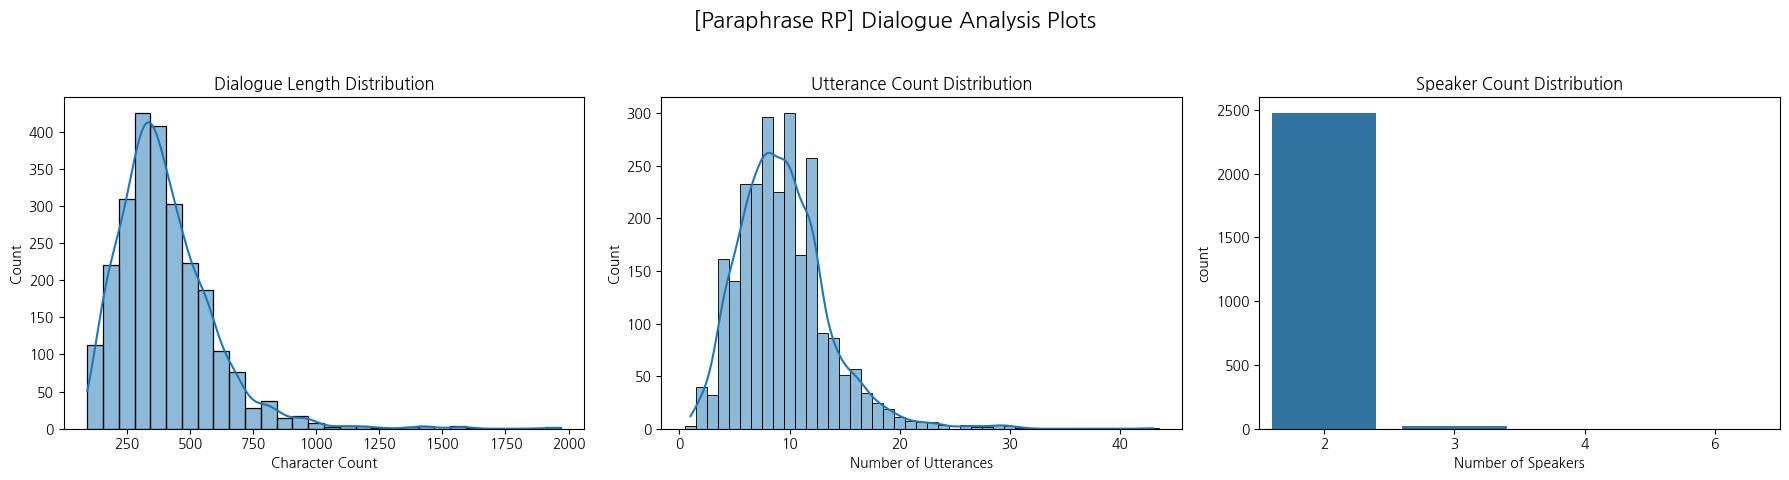

Paraphrase RP 요약문 분석
=== 길이 분석 ===
총 샘플 수: 2498
평균 길이: 88.0자
중앙값: 82.0자
표준편차: 34.0자
최소/최대: 14/345자
사분위수: Q1=63, Q3=106

=== 화자 언급 횟수 ===
화자 0명 언급: 375개 (15.0%)
화자 1명 언급: 370개 (14.8%)
화자 2명 언급: 998개 (40.0%)
화자 3명 언급: 444개 (17.8%)
화자 4명 언급: 223개 (8.9%)
화자 5명 언급: 62개 (2.5%)
화자 6명 언급: 19개 (0.8%)
화자 7명 언급: 6개 (0.2%)
화자 8명 언급: 1개 (0.0%)

=== 문장 시작 패턴 ===
other: 669개 (26.8%)
person_first: 1829개 (73.2%)

=== 특수 패턴 ===
따옴표 포함: 47개 (1.9%)
숫자 포함: 2183개 (87.4%)

=== 요약문 샘플 (무작위 5개) ===

[샘플 1] (길이: 54자)
#Person1#은 Sam으로부터 주식을 팔지 않으면 큰 손실을 입을 수 있다는 경고를 듣습니다.

[샘플 2] (길이: 83자)
#Person1#은 잘못 청구된 $10을 환불받았으나, $2의 추가 요금에 불만을 표시했습니다. #Person2#는 이 요금의 필요성을 설명했습니다.

[샘플 3] (길이: 85자)
#Person1#은 Mr. Sutcliffe에게 사무실 분위기와 직원들이 마음에 들지 않고, 그와의 관계도 맞지 않아 부서를 이동하고 싶다고 전했습니다.

[샘플 4] (길이: 62자)
#Person1#은 #Person2#에게 급여 인상이 없어 불만족스러워서 새로운 직장을 찾기로 했다고 말합니다.

[샘플 5] (길이: 92자)
#Person2#는 #Person1#에게 호스트 가족과 살 수 있게 도움을 요청합니다. #Person2#는 영어 실력과 입주 계획을 #Person1#에게 설명합니다.


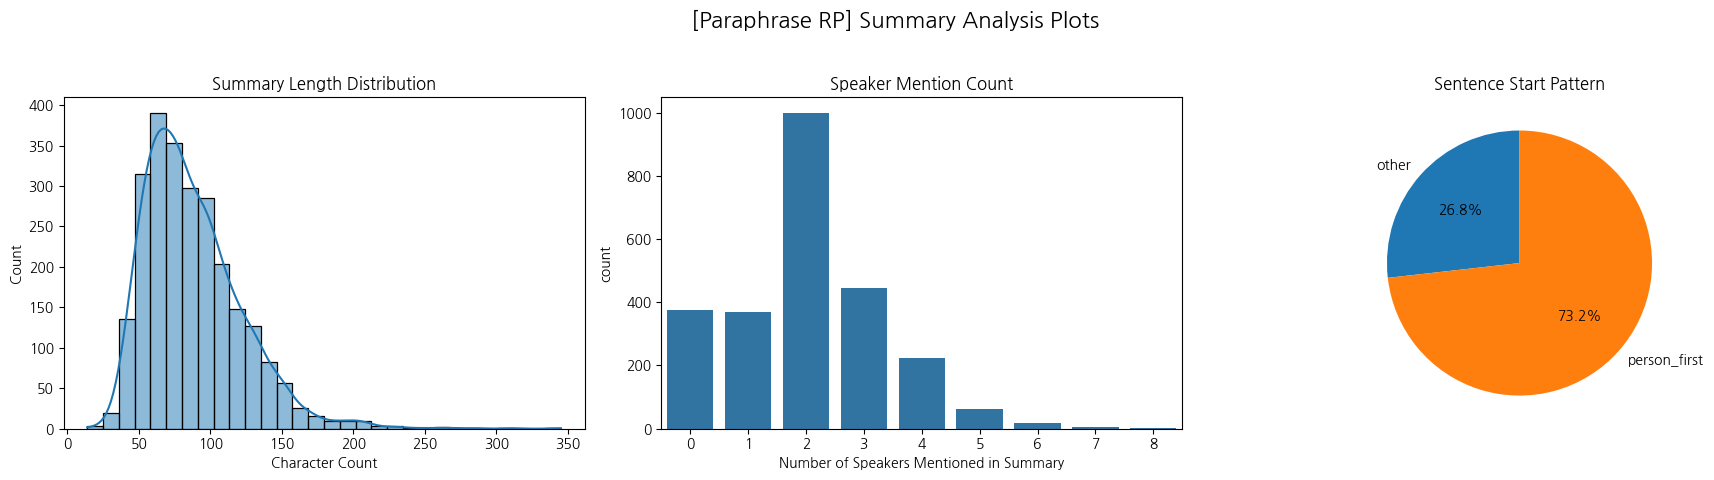


Paraphrase RP 토픽 분석


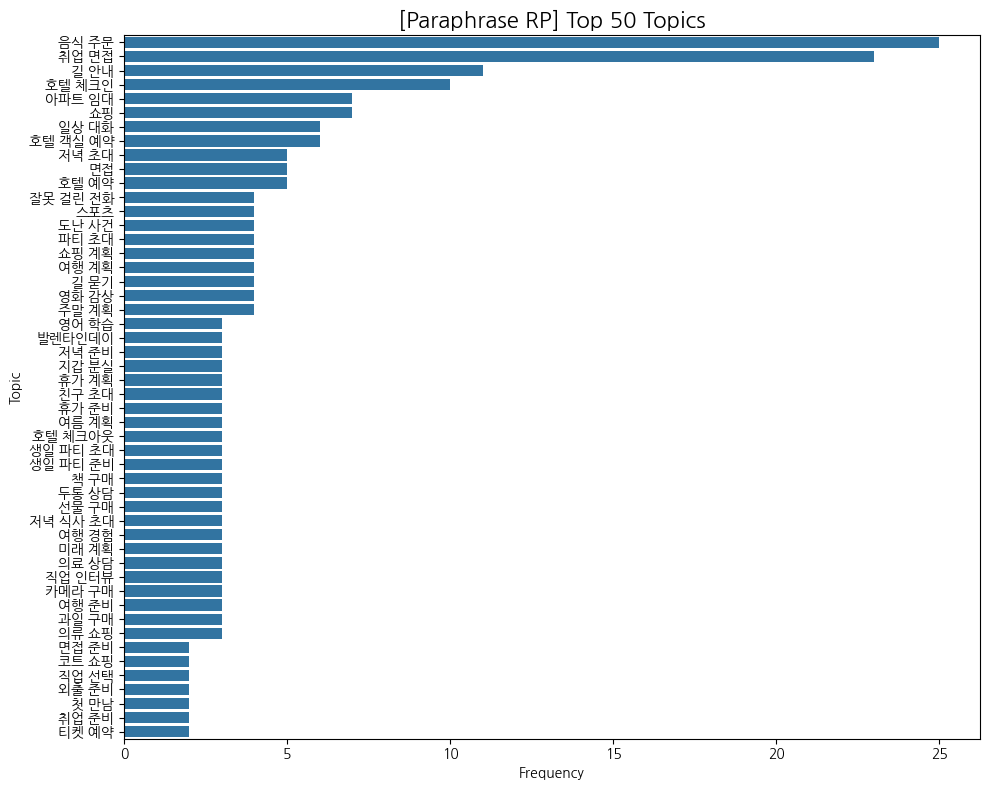


                    SS 증강 데이터셋 정보
=== 대화 길이 분석 ===
평균 길이: 403자
중앙값: 370자
최소/최대: 91/2150자

=== 발화 수 분석 ===
평균 발화 수: 9.3개
중앙값: 9개
최소/최대: 1/33개

=== 화자 수 분석 ===
평균 화자 수: 2.00명
2명 대화: 2500개 (100.0%)

=== 등장 화자 종류 ===
#Person1#: 2500회 등장
#Person2#: 2500회 등장

=== 대화문 샘플 (짧은 것 1개) ===
[길이: 91자, 발화 수: 2개]
#Person2#: 여행 가서 새 카메라 잘 썼겠네.
#Person1#: 그러려고 했는데, 여행 가려고 산 새 카메라를 공항까지 데려다 준 친구 차에 두고 내렸어.

Speaker Swap SS 대화문 분석


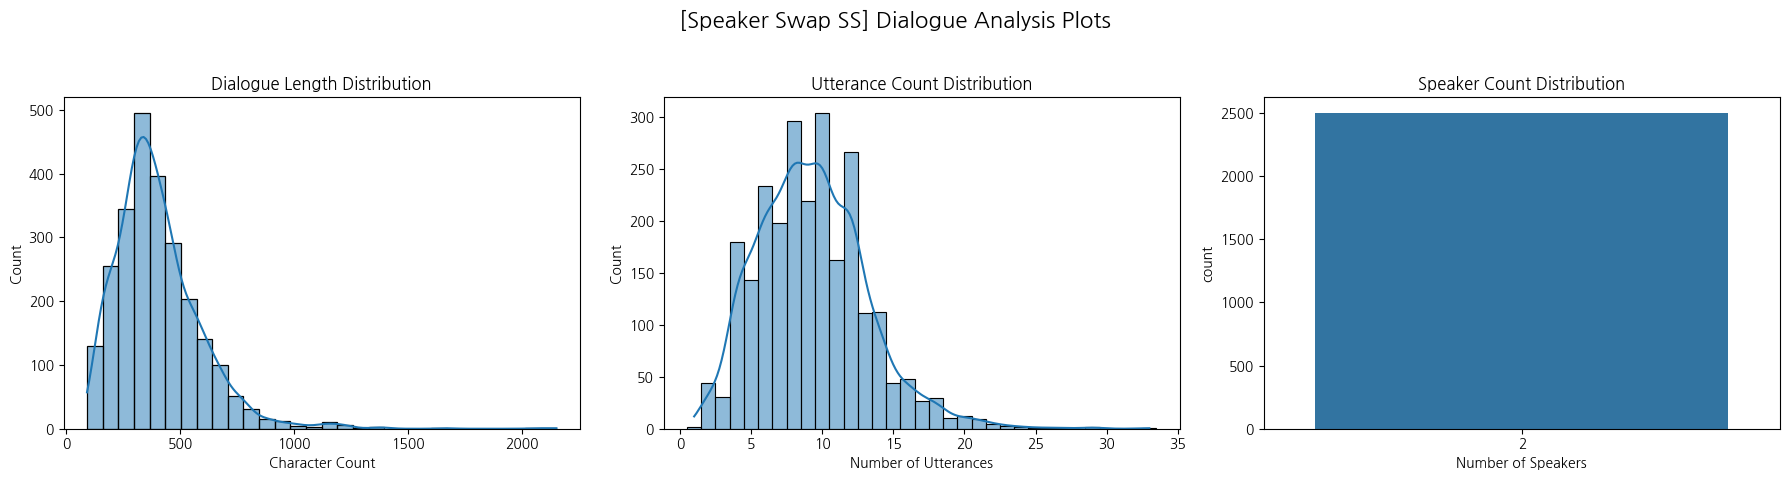

Speaker Swap SS 요약문 분석
=== 길이 분석 ===
총 샘플 수: 2500
평균 길이: 85.2자
중앙값: 80.0자
표준편차: 32.6자
최소/최대: 16/315자
사분위수: Q1=61, Q3=102

=== 화자 언급 횟수 ===
화자 0명 언급: 349개 (14.0%)
화자 1명 언급: 363개 (14.5%)
화자 2명 언급: 971개 (38.8%)
화자 3명 언급: 509개 (20.4%)
화자 4명 언급: 218개 (8.7%)
화자 5명 언급: 63개 (2.5%)
화자 6명 언급: 20개 (0.8%)
화자 7명 언급: 4개 (0.2%)
화자 8명 언급: 2개 (0.1%)
화자 9명 언급: 1개 (0.0%)

=== 문장 시작 패턴 ===
person_first: 1931개 (77.2%)
other: 569개 (22.8%)

=== 특수 패턴 ===
따옴표 포함: 44개 (1.8%)
숫자 포함: 2187개 (87.5%)

=== 요약문 샘플 (무작위 5개) ===

[샘플 1] (길이: 108자)
#Person1#는 #Person2#에게 사업에서 가장 중요한 것은 비용을 절감하고 수익을 증가시키는 것이라고 설명합니다. 또한, 매출을 극대화하는 방법과 가격 책정 방식에 대해서도 언급합니다.

[샘플 2] (길이: 172자)
#Person1#는 #Person2#의 불법 주차된 차량을 견인하려 하고, #Person2#은 나뭇가지가 표지판을 가리고 있었다며 설명합니다. #Person1#는 이를 수용하지 않고 티켓을 발급하며, #Person2#은 강의 티켓과 식당 쿠폰을 제안하지만 #Person1#는 뇌물 제공은 불법이라고 답합니다.

[샘플 3] (길이: 72자)
#Person2#은 #Person1#에게 건강 검진을 권유하지만, #Person1#는 중요한 사업을 먼저 정리하고 싶다고 답한다.

[샘플 4] (길이: 97자)
#Person2#이 #Person1#을 깨우지만, #Person1#는 5분 더 자고 싶어 합니다. 결국 #Person2#은 #

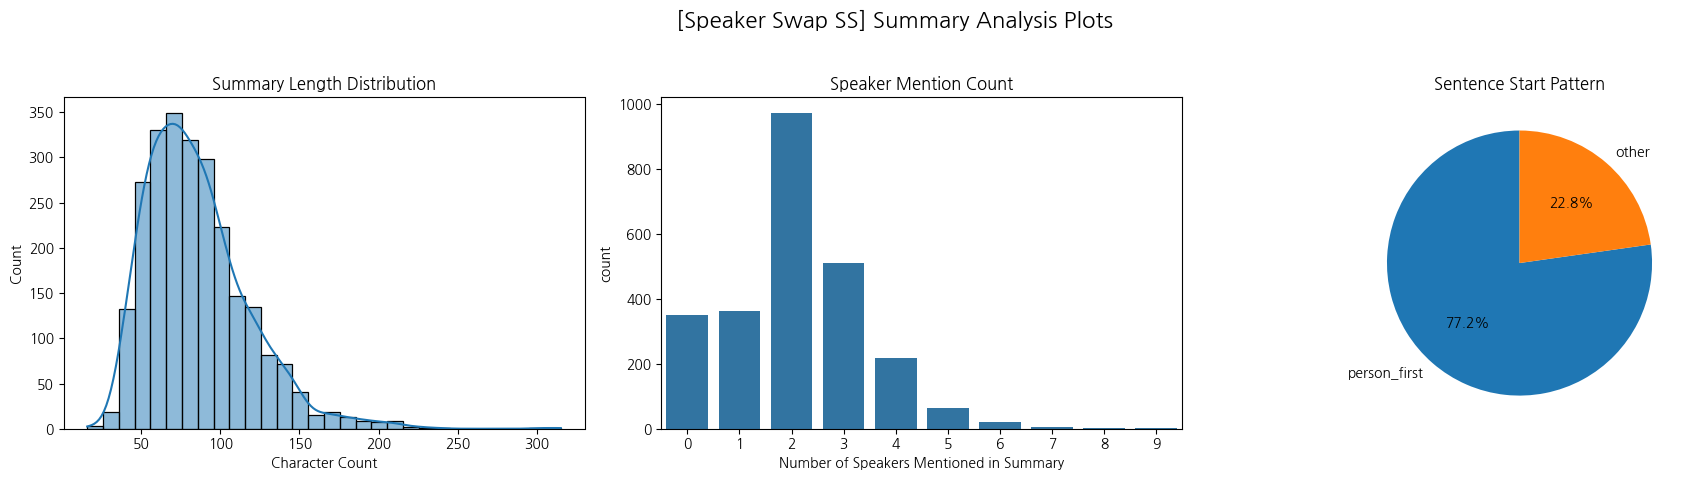


Speaker Swap SS 토픽 분석


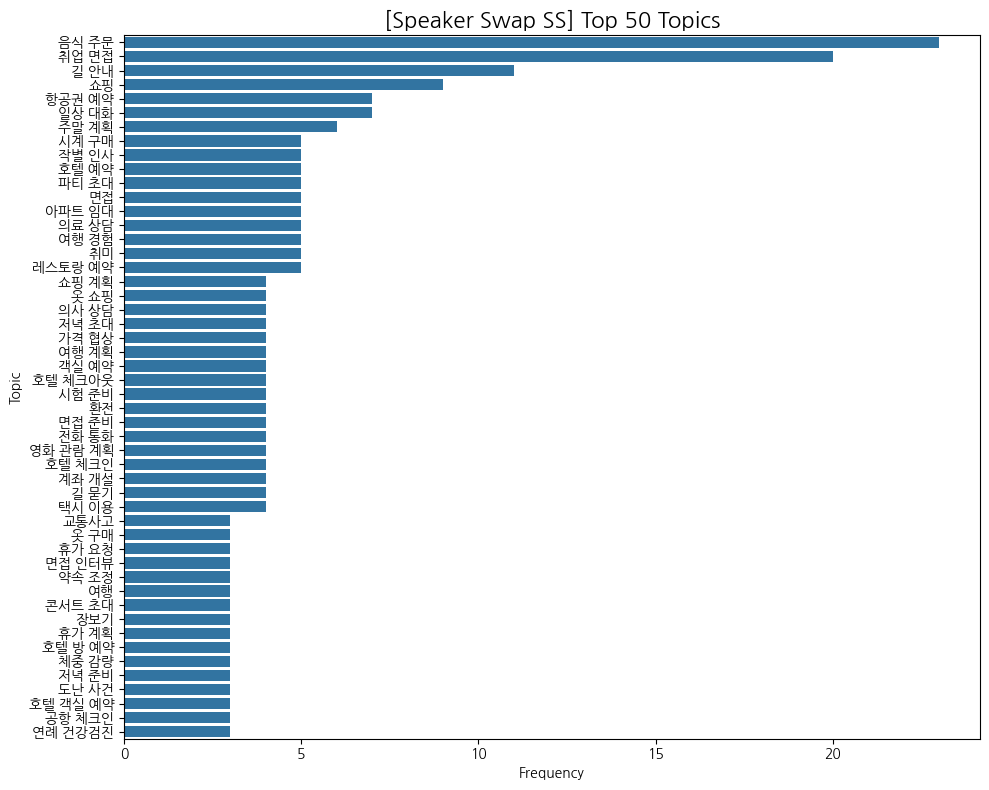


                    Synthetic 증강 데이터셋 정보
=== 대화 길이 분석 ===
평균 길이: 427자
중앙값: 410자
최소/최대: 155/1466자

=== 발화 수 분석 ===
평균 발화 수: 8.5개
중앙값: 8개
최소/최대: 3/16개

=== 화자 수 분석 ===
평균 화자 수: 2.00명
2명 대화: 999개 (99.9%)
4명 대화: 1개 (0.1%)

=== 등장 화자 종류 ===
#Person1#: 1000회 등장
#Person2#: 1000회 등장
#Person3#: 1회 등장
#Person4#: 1회 등장

=== 대화문 샘플 (짧은 것 1개) ===
[길이: 155자, 발화 수: 4개]
#Person1#: 안녕, #Person2#. 통화하려고 했는데 시간이 어때?
#Person2#: 안녕, #Person1#. 지금 좀 바쁘지만 한 30분 정도 뒤에 시간 돼.
#Person1#: 그럼 30분 후에 전화해도 괜찮아?
#Person2#: 네, 그렇게 해. 기다릴게.

Synthetic 대화문 분석


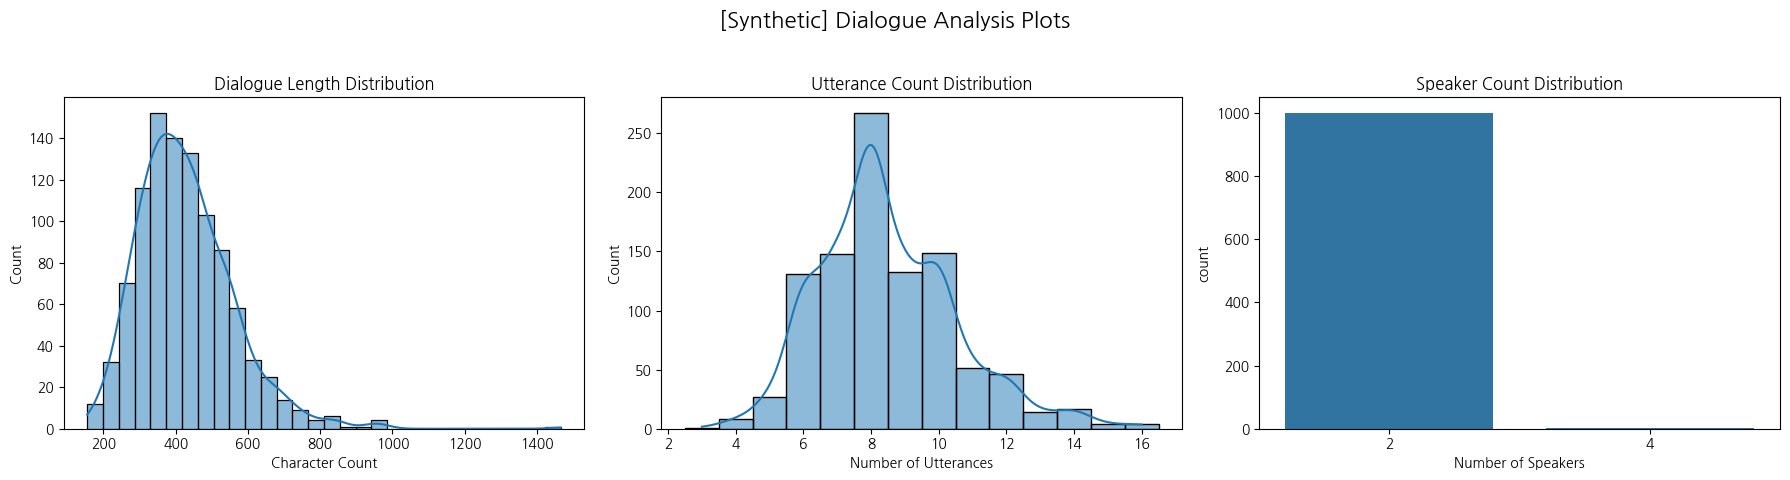

Synthetic 요약문 분석
=== 길이 분석 ===
총 샘플 수: 1000
평균 길이: 111.6자
중앙값: 108.0자
표준편차: 35.0자
최소/최대: 36/284자
사분위수: Q1=86, Q3=132

=== 화자 언급 횟수 ===
화자 0명 언급: 43개 (4.3%)
화자 2명 언급: 452개 (45.2%)
화자 3명 언급: 282개 (28.2%)
화자 4명 언급: 166개 (16.6%)
화자 5명 언급: 45개 (4.5%)
화자 6명 언급: 9개 (0.9%)
화자 7명 언급: 2개 (0.2%)
화자 8명 언급: 1개 (0.1%)

=== 문장 시작 패턴 ===
person_first: 948개 (94.8%)
other: 52개 (5.2%)

=== 특수 패턴 ===
따옴표 포함: 81개 (8.1%)
숫자 포함: 962개 (96.2%)

=== 요약문 샘플 (무작위 5개) ===

[샘플 1] (길이: 93자)
#Person1#는 해외 여행에서 구입한 물건들을 세관 신고해야 하는지 묻고, #Person2#는 어떤 물건들이 신고 대상인지, 어떻게 신고할 수 있는지 설명해줍니다.

[샘플 2] (길이: 126자)
#Person1#은 #Person2#에게 2베드룸 아파트 임대에 대해 문의하고, A동 502호에 대해 자세히 물어봅니다. #Person2#는 A동 502호의 특징과 임대료를 설명하고, 오늘 오후 3시에 방문 예약을 잡아줍니다.

[샘플 3] (길이: 123자)
#Person1#과 #Person2#가 고기 장보기에 대해 이야기합니다. #Person1#은 주말에 바비큐 파티를 위해 삼겹살, 갈빗살, 소고기, 채소, 마늘, 버섯을 사러 가자고 제안하고 #Person2#가 동의합니다.

[샘플 4] (길이: 79자)
#Person2#는 #Person1#에게 몰몬교의 독특한 신앙 체계, 몰몬경의 내용, 그리고 몰몬교 신자들의 중요한 의식들에 대해 설명합니다.

[샘플 5] (길이: 64자)
#Person1#와 #Person2#는 휴가용 집을 고르기 위해

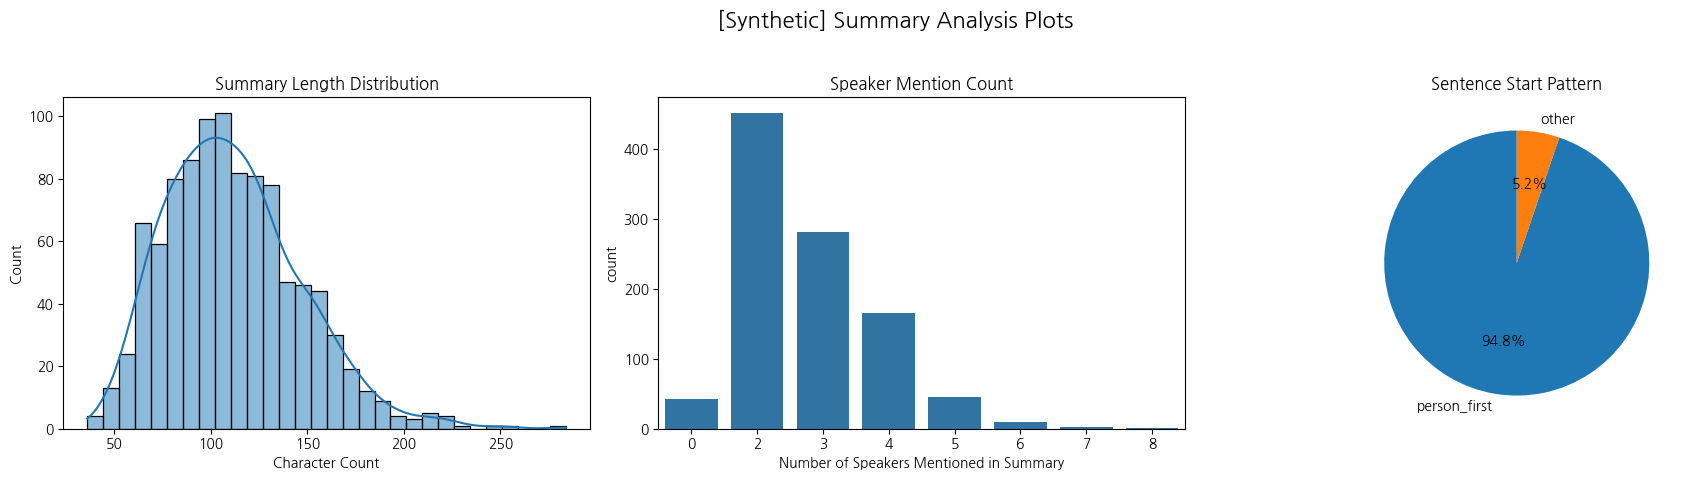


Synthetic 토픽 분석


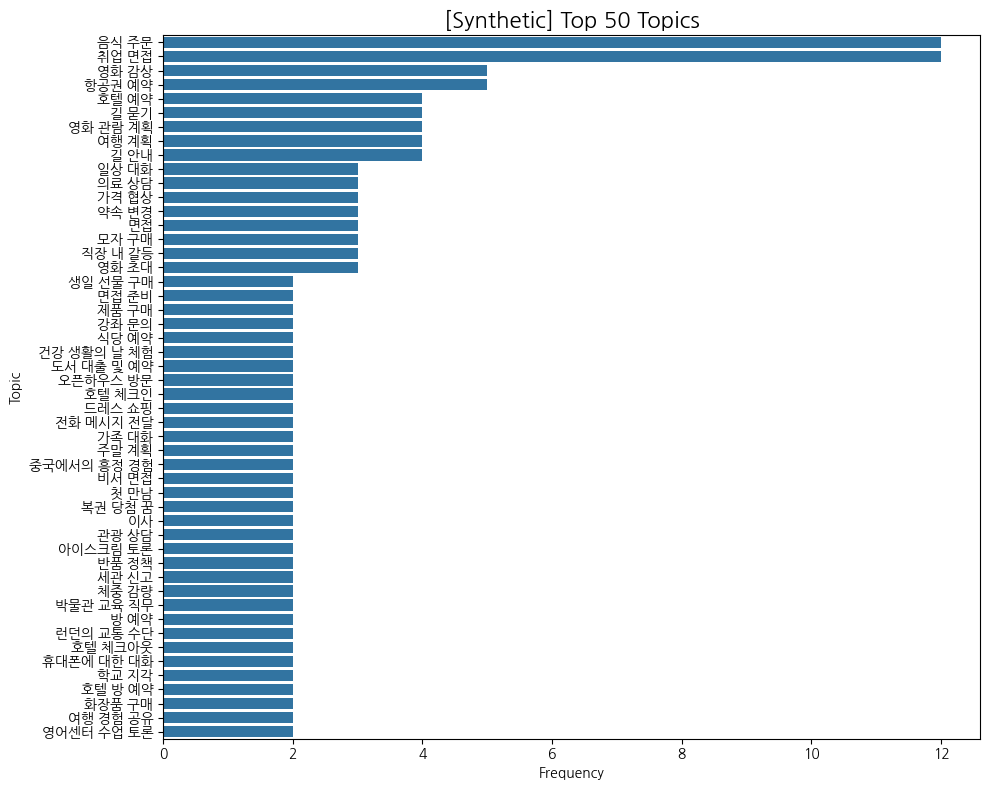


                    증강 포함 전체 train 데이터셋 정보
=== 대화 길이 분석 ===
평균 길이: 406자
중앙값: 372자
최소/최대: 84/2165자

=== 발화 수 분석 ===
평균 발화 수: 9.4개
중앙값: 9개
최소/최대: 1/59개

=== 화자 수 분석 ===
평균 화자 수: 2.01명
2명 대화: 18308개 (99.2%)
3명 대화: 129개 (0.7%)
4명 대화: 12개 (0.1%)
5명 대화: 3개 (0.0%)
6명 대화: 2개 (0.0%)
7명 대화: 1개 (0.0%)

=== 등장 화자 종류 ===
#Person1#: 18455회 등장
#Person2#: 18455회 등장
#Person3#: 147회 등장
#Person4#: 18회 등장
#Person5#: 6회 등장
#Person6#: 3회 등장
#Person7#: 1회 등장

=== 대화문 샘플 (짧은 것 1개) ===
[길이: 84자, 발화 수: 2개]
#Person1#: 또 인터넷이야? 언제 그만할 거야? 토크쇼 시간이라고. 
#Person2#: 잠깐만, 보고 있어. 엄마 생일 선물 제대로 고르려고.

Train All 대화문 분석


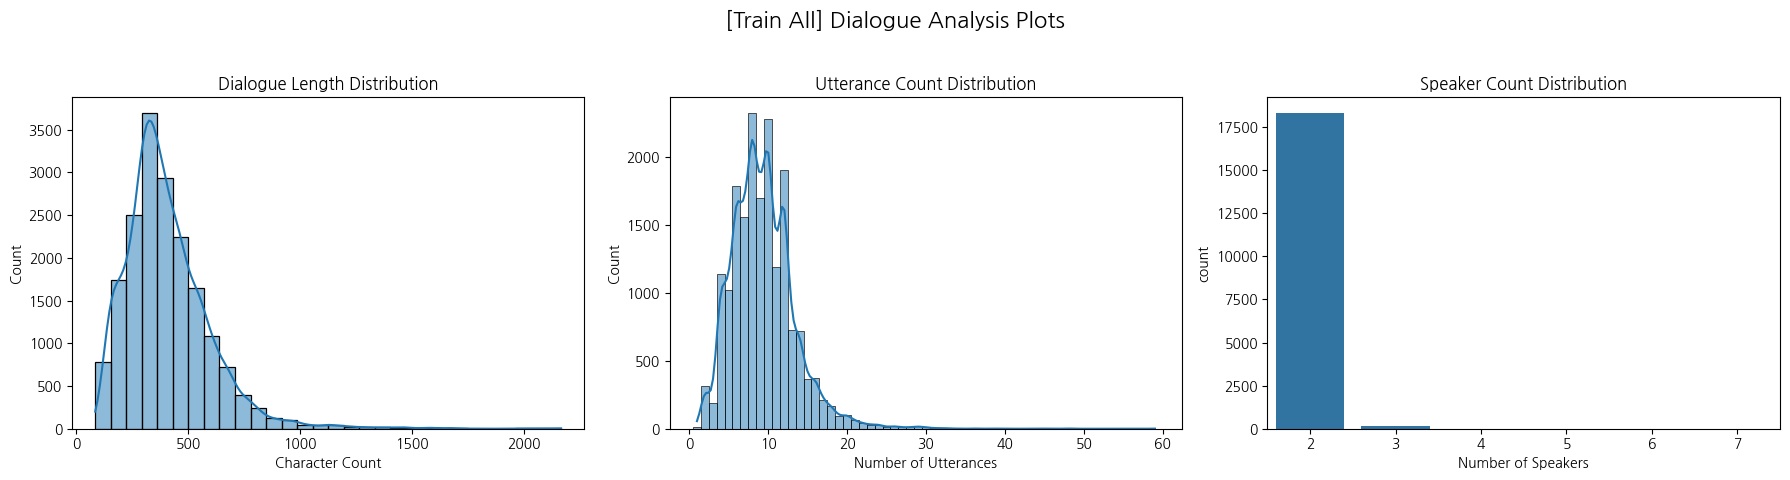

Train All 요약문 분석
=== 길이 분석 ===
총 샘플 수: 18455
평균 길이: 87.4자
중앙값: 82.0자
표준편차: 34.3자
최소/최대: 13/376자
사분위수: Q1=62, Q3=106

=== 화자 언급 횟수 ===
화자 0명 언급: 2527개 (13.7%)
화자 1명 언급: 2570개 (13.9%)
화자 2명 언급: 7193개 (39.0%)
화자 3명 언급: 3711개 (20.1%)
화자 4명 언급: 1724개 (9.3%)
화자 5명 언급: 508개 (2.8%)
화자 6명 언급: 162개 (0.9%)
화자 7명 언급: 42개 (0.2%)
화자 8명 언급: 14개 (0.1%)
화자 9명 언급: 4개 (0.0%)

=== 문장 시작 패턴 ===
person_first: 14293개 (77.4%)
other: 4162개 (22.6%)

=== 특수 패턴 ===
따옴표 포함: 366개 (2.0%)
숫자 포함: 16268개 (88.1%)

=== 요약문 샘플 (무작위 5개) ===

[샘플 1] (길이: 83자)
#Person2#는 #Person1#이 자주 메시지를 확인하고 핸드폰을 항상 가지고 다니기 때문에 '정보 과부하' 중독에 걸릴 수 있다고 설명합니다.

[샘플 2] (길이: 103자)
#Person1#는 금요일 밤 농구 경기를 보지 못했습니다. #Person2#은 경기가 매우 흥미진진했다고 전합니다. #Person1#는 경기에 참석하지 못해 아쉬움을 느끼고 있습니다.

[샘플 3] (길이: 129자)
#Person1#는 여러 은행에 지원서를 제출했습니다. #Person2#는 마케팅 분야에서 일하고 싶어합니다. #Person1#는 #Person2#에게 은행에도 지원해보라고 제안하며, #Person2#는 이를 긍정적으로 생각합니다.

[샘플 4] (길이: 117자)
#Person2#는 십자말풀이를 좋아하고, #Person1#는 다트를 즐깁니다. #Person1#는 #Person2#의 나라 사람들이 모두 마작 고수인 줄 알았지만, #Pers

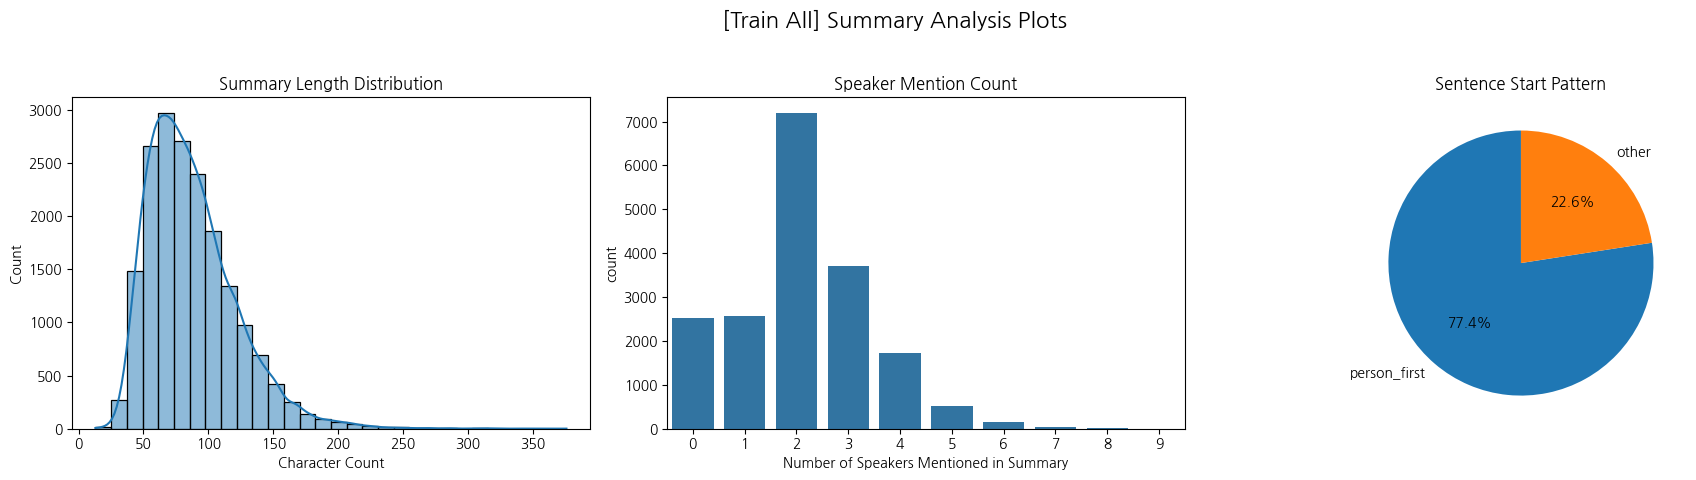


Train All 토픽 분석


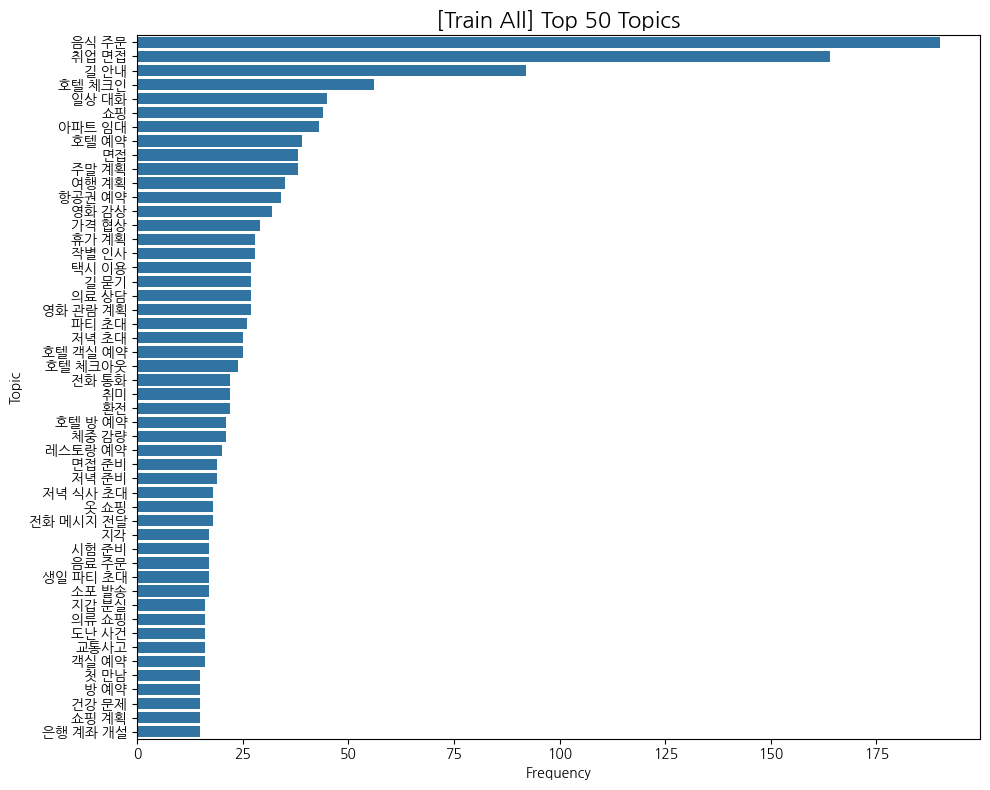

In [14]:
print("\n" + "="*70)
print(" "*20 + "RP 증강 데이터셋 정보")
print("="*70)

# Paraphrase (rp) 분석
train_rp_dialogue_stats = analyze_dialogues(train_augmented_rp, "Paraphrase RP")
train_rp_summary_stats = analyze_summaries(train_augmented_rp, "Paraphrase RP")
train_rp_topic_stats = analyze_topics(train_augmented_rp, "Paraphrase RP")

print("\n" + "="*70)
print(" "*20 + "SS 증강 데이터셋 정보")
print("="*70)

# Speaker Swap (ss) 분석
train_ss_dialogue_stats = analyze_dialogues(train_augmented_ss, "Speaker Swap SS")
train_ss_summary_stats = analyze_summaries(train_augmented_ss, "Speaker Swap SS")
train_ss_topic_stats = analyze_topics(train_augmented_ss, "Speaker Swap SS")

print("\n" + "="*70)
print(" "*20 + "Synthetic 증강 데이터셋 정보")
print("="*70)

# Synthetic 데이터 분석
train_syn_dialogue_stats = analyze_dialogues(train_augmented_synthetic, "Synthetic")
train_syn_summary_stats = analyze_summaries(train_augmented_synthetic, "Synthetic")
train_syn_topic_stats = analyze_topics(train_augmented_synthetic, "Synthetic")

print("\n" + "="*70)
print(" "*20 + "증강 포함 전체 train 데이터셋 정보")
print("="*70)

# 전체 증강 데이터 분석
train_aug_dialogue_stats = analyze_dialogues(train_augmented, "Train All")
train_aug_summary_stats = analyze_summaries(train_augmented, "Train All")
train_aug_topic_stats = analyze_topics(train_augmented, "Train All")


In [15]:
df = pd.concat([train_augmented_rp, train_augmented_synthetic])

# ss를 제외한 증강된 데이터셋의 각 dialogue가 '#Person1#'으로 시작하는지 여부
starts_with_person1 = df['dialogue'].str.strip().str.startswith('#Person1#')

# 개수 확인
total = len(df)
count_person1 = starts_with_person1.sum()
print(f"#Person1#으로 시작: {count_person1}/{total}")

#Person1#으로 시작: 3498/3498


In [16]:
def detect_noise(df, dataset_name=""):
    """노이즈 패턴 탐지"""
    
    print("="*70)
    print(f"{dataset_name} 노이즈 분석")
    print("="*70)
    
    dialogues = df['dialogue'].values
    summaries = df['summary'].values if 'summary' in df.columns else None
    
    # 1. \\n 패턴 (escaped newline)
    escaped_newline = [i for i, d in enumerate(dialogues) if '\\n' in d]
    
    # 2. <br> 태그
    br_tag = [i for i, d in enumerate(dialogues) if '<br>' in d.lower()]

    # 6. Summary의 노이즈 (있는 경우)
    summary_noise = {}
    if summaries is not None:
        summary_noise = {
            'escaped_newline': [i for i, s in enumerate(summaries) if pd.notna(s) and '\\n' in s],
            'br_tag': [i for i, s in enumerate(summaries) if pd.notna(s) and '<br>' in s.lower()],
            'multi_space': [i for i, s in enumerate(summaries) if pd.notna(s) and '  ' in s],
        }
    
    # 결과 출력
    print(f"\n[Dialogue 노이즈]")
    print(f"  \\n (escaped newline): {len(escaped_newline)}개 ({len(escaped_newline)/len(dialogues)*100:.2f}%)")
    print(f"  <br> 태그: {len(br_tag)}개 ({len(br_tag)/len(dialogues)*100:.2f}%)")
    
    if summaries is not None:
        print(f"\n[Summary 노이즈]")
        for noise_type, indices in summary_noise.items():
            print(f"  {noise_type}: {len(indices)}개 ({len(indices)/len(summaries)*100:.2f}%)")
    
    # 노이즈 예시 출력
    print(f"\n{'='*70}")
    print("노이즈 예시")
    print(f"{'='*70}")
    
    if escaped_newline:
        print(f"\n[\\n (escaped newline) 예시]")
        idx = escaped_newline[0]
        print(f"Dialogue (raw): {repr(dialogues[idx][:200])}")
        print(f"Dialogue (print): {dialogues[idx][:200]}")
    
    if br_tag:
        print(f"\n[<br> 태그 예시]")
        idx = br_tag[0]
        print(f"Dialogue: {dialogues[idx][:300]}")
    
    return {
        'escaped_newline': escaped_newline,
        'br_tag': br_tag,
        'summary_noise': summary_noise
    }

def analyze_all_noise(train_df, dev_df, test_df):
    """전체 데이터셋 노이즈 분석"""
    
    print("\n" + "="*70)
    print(" "*20 + "전체 노이즈 분석")
    print("="*70)
    
    train_noise = detect_noise(train_df, "TRAIN")
    dev_noise = detect_noise(dev_df, "DEV")
    test_noise = detect_noise(test_df, "TEST")
    
    return train_noise, dev_noise, test_noise


# 실행
if __name__ == "__main__":
    analyze_all_noise(train_augmented_rp, train_augmented_ss, train_augmented_synthetic)


                    전체 노이즈 분석
TRAIN 노이즈 분석

[Dialogue 노이즈]
  \n (escaped newline): 0개 (0.00%)
  <br> 태그: 0개 (0.00%)

[Summary 노이즈]
  escaped_newline: 0개 (0.00%)
  br_tag: 0개 (0.00%)
  multi_space: 0개 (0.00%)

노이즈 예시
DEV 노이즈 분석

[Dialogue 노이즈]
  \n (escaped newline): 0개 (0.00%)
  <br> 태그: 0개 (0.00%)

[Summary 노이즈]
  escaped_newline: 0개 (0.00%)
  br_tag: 0개 (0.00%)
  multi_space: 0개 (0.00%)

노이즈 예시
TEST 노이즈 분석

[Dialogue 노이즈]
  \n (escaped newline): 0개 (0.00%)
  <br> 태그: 0개 (0.00%)

[Summary 노이즈]
  escaped_newline: 0개 (0.00%)
  br_tag: 0개 (0.00%)
  multi_space: 0개 (0.00%)

노이즈 예시
